In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import re
import matplotlib.pyplot as plt

%matplotlib inline
# ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('./felix_cleaned.csv')

In [3]:
# Grouping by the 'class' column and computing the mean for each group
means_by_class = df.groupby('class')[['ndvi_4_month', 'ndvi_5_month', 'ndvi_6_month', 'ndvi_7_month', 'ndvi_8_month']].mean()

print(means_by_class)


       ndvi_4_month  ndvi_5_month  ndvi_6_month  ndvi_7_month  ndvi_8_month
class                                                                      
1          0.045227      0.156877      0.069063      0.058472      0.045687
2          0.009710      0.066526      0.087089      0.093434      0.102546
3          0.044129      0.170207      0.112791      0.036486      0.012656
4          0.007094      0.043729      0.081198      0.119854      0.122260
5          0.022002      0.160325      0.140854      0.039091      0.014594
6         -0.003472      0.017917      0.032750      0.102667      0.250278


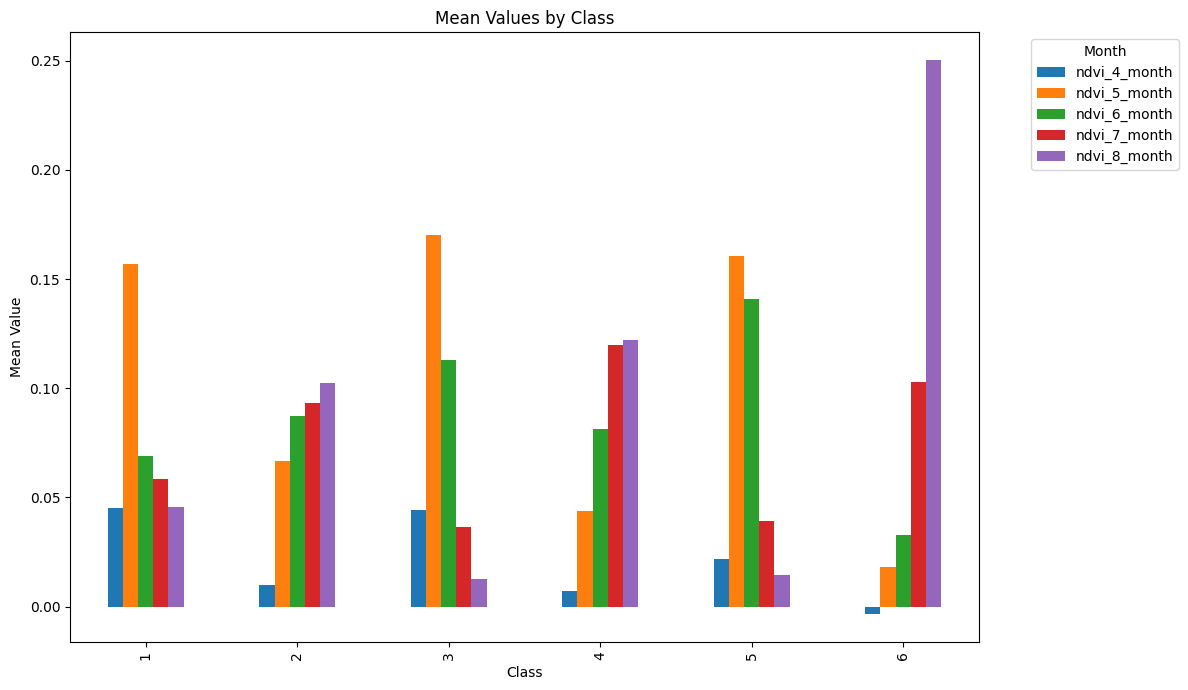

In [4]:
import matplotlib.pyplot as plt

# Plotting the means for each class
means_by_class.plot(kind='bar', figsize=(12, 7))

plt.title('Mean Values by Class')
plt.ylabel('Mean Value')
plt.xlabel('Class')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [5]:
df = df[df['class']!=3]
df = df[df['class']!=4]

In [6]:
# Splitting the data
X = df.drop(['class'], axis=1)  # Features excluding 'id' and 'class'
y = df['class']  # Target variable

In [7]:
y.value_counts()

class
2    27
5    20
1    15
6     9
Name: count, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [9]:
imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [10]:
# Defining the parameter grid for GradientBoostingClassifier
param_dist = {
    'n_estimators': [10, 50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Instantiating GradientBoostingClassifier
gbm = GradientBoostingClassifier()

# Setting up RandomizedSearchCV
random_search = RandomizedSearchCV(
    gbm, param_distributions=param_dist, n_iter=100, scoring='accuracy', 
    cv=5, verbose=1, n_jobs=-1
)

# Fitting the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Getting the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Evaluate on the test set
print("Test Set Score:", random_search.score(X_test, y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.5}
Best Score: 0.6333333333333333
Test Set Score: 0.5


In [11]:
y.value_counts()

class
2    27
5    20
1    15
6     9
Name: count, dtype: int64

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [13]:
y_pred = random_search.predict(X_test)

# Calculate accuracy and generate a confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [14]:
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.5
Confusion Matrix:
[[2 2 1 0]
 [2 6 0 0]
 [1 2 2 1]
 [2 0 0 1]]
